In [1]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [ ]:
X,y = spiral_data(samples=100,classes=3)

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)

In [3]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)

In [4]:
# Softmax activation
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
        keepdims=True)
        self.output = probabilities
    
    def backward(self,dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index,(single_output,single_dvalue) in enumerate(zip(self.output,dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalue)
            

In [5]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [17]:
class CrossEntropyLoss:
    def calculate(self,ypred,ytrue):
        if len(ytrue.shape) == 2:
            ytrue = np.argmax(ytrue,axis=1)
        ypred = np.clip(ypred,1e-7,1-1e-7)
        return np.mean(-np.log(ypred[range(len(ypred)),ytrue]))
    
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


In [18]:
class Activation_Softmax_CrossEntropy_loss:
   # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = CrossEntropyLoss()
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        

In [19]:
class SGD_Optimizer():
    def __init__(self,lr=0.1):
        self.lr = lr
    def update_params(self,layer):
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases
        
        

In [ ]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2,64)

activation1 = Activation_ReLU()

dense2 = Layer_Dense(64,3)

loss_activation = Activation_Softmax_CrossEntropy_loss()

optimizer = SGD_Optimizer(lr=1)

In [ ]:
for epoch in range(1001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)


In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [10]:
X,y = make_blobs(n_samples=100,centers=3,random_state=0)

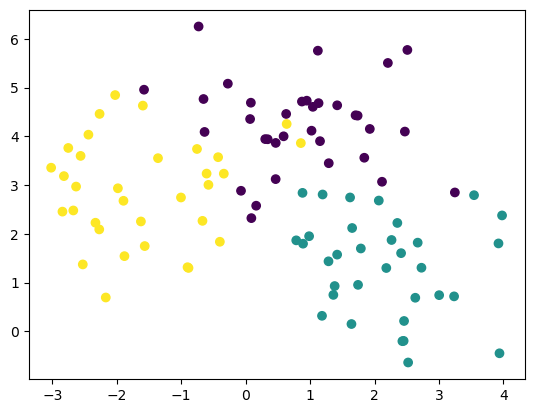

In [11]:
plt.scatter(X[:,0],X[:,1],c=y)

In [16]:
layer1 = Layer_Dense(2,16)
act = Activation_ReLU()
layer2 = Layer_Dense(16,3)
lossact = Activation_Softmax_CrossEntropy_loss()
optimizer = SGD_Optimizer()

for epoch in range(5001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = lossact.forward(layer2.output,y)
    
    if epoch % 100 == 0:
        predictions = np.argmax(lossact.output, axis=1)
        accuracy = np.mean(predictions==y)
        print(f"Epoch : {epoch} , Acc : {accuracy} , Loss : {loss}")
    
    lossact.backward(lossact.output,y)
    layer2.backward(lossact.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)
    
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch : 0 , Acc : 0.15 , Loss : 1.0985599366787648
Epoch : 100 , Acc : 0.89 , Loss : 0.4046705170251919
Epoch : 200 , Acc : 0.9 , Loss : 0.2968369570025056
Epoch : 300 , Acc : 0.91 , Loss : 0.27338409135388486
Epoch : 400 , Acc : 0.92 , Loss : 0.25789803866583577
Epoch : 500 , Acc : 0.91 , Loss : 0.24732606664343706
Epoch : 600 , Acc : 0.91 , Loss : 0.2399833568037278
Epoch : 700 , Acc : 0.9 , Loss : 0.2347839360435083
Epoch : 800 , Acc : 0.9 , Loss : 0.22948254695876652
Epoch : 900 , Acc : 0.91 , Loss : 0.22462588612054749
Epoch : 1000 , Acc : 0.92 , Loss : 0.22020506725300096
Epoch : 1100 , Acc : 0.92 , Loss : 0.2170395793238717
Epoch : 1200 , Acc : 0.92 , Loss : 0.21418211068990778
Epoch : 1300 , Acc : 0.92 , Loss : 0.21157719034676095
Epoch : 1400 , Acc : 0.92 , Loss : 0.20916835139501874
Epoch : 1500 , Acc : 0.92 , Loss : 0.2068824684378857
Epoch : 1600 , Acc : 0.92 , Loss : 0.20471101615257123
Epoch : 1700 , Acc : 0.92 , Loss : 0.20258731124085863
Epoch : 1800 , Acc : 0.92 , Loss

In [ ]:
act.output

In [ ]:
import numpy as np
# Passed in gradient from the next layer
# for the purpose of this example we're going to use
# an array of an incremental gradient values
dvalues = np.array([[1., 1., 1.],
[2., 2., 2.],
[3., 3., 3.]])
# We have 3 sets of inputs - samples
inputs = np.array([[1, 2, 3, 2.5],
[2., 5., -1., 2],
[-1.5, 2.7, 3.3, -0.8]])
# We have 3 sets of weights - one set for each neuron
# we have 4 inputs, thus 4 weights
# recall that we keep weights transposed
weights = np.array([[0.2, 0.8, -0.5, 1],
[0.5, -0.91, 0.26, -0.5],
[-0.26, -0.27, 0.17, 0.87]]).T

# One bias for each neuron
# biases are the row vector with a shape (1, neurons)
biases = np.array([[2, 3, 0.5]])
# Forward pass
layer_outputs = np.dot(inputs, weights) + biases # Dense layer
relu_outputs = np.maximum(0, layer_outputs) # ReLU activation
# Let's optimize and test backpropagation here
# ReLU activation - simulates derivative with respect to input values
# from next layer passed to current layer during backpropagation
drelu = relu_outputs.copy()
drelu[layer_outputs <= 0] = 0

dweights = np.dot(inputs.T,drelu)
dbiases = np.sum(drelu,axis=0,keepdims=True)
dinputs = np.dot(drelu,weights.T)

dweights
dbiases
dinputs

lossact.output